#  **SM64 Speedruns - A SQL and Python Project**

\** **Ignore any redundant / unnecessary comments, they're mainly just notes for me because I am a noob :]**

Learning Python for data analysis / science and wanted to test what I've learned so far on a personal project using a dataset from Kaggle. (https://www.kaggle.com/code/mcpenguin/super-mario-64-speedruns-data-collection) This dataset
\
\
Updated the dataset files to include a RUN_ID column to later replace the original "id" column. Updated the PLACE column for each PLATFORM. On speedrun.com the platforms are in separate tabs with their own placing.
\
\
Learned (from doing this project):
\
    1. 
\
\
I also haven't used git in a while so this is also sort of a guinea pig for re-learning that.

## **Gather and Cleanse Data**

### **SQLite Connection**

In [1]:
import pandas as pd
import seaborn as sns
# Learned the purpose of importing an aliased [module].[interface] and then just the [module], but with a diff alias.
# -- Mainly to access separate operations of the module. i.e. changing the graph's style with mpl, and access the plotting operations with plt.
import matplotlib as mpl
import matplotlib.pyplot as plt

import sqlite3
import os
import dateutil, datetime

# Connection Object to establish connection to a sqlite3 database.
connObj = sqlite3.connect('SPEEDRUNS.db')
cursorObj = connObj.cursor()

%load_ext sql
%sql sqlite:///SPEEDRUNS.db

In [2]:
# Assigning the datasets location for SM64 Speedruns to a variable called "repo"
repo = r'./Data/'
full_path_to_dataset = os.path.join(repo, 'ALL_CATEGORIES.csv')

# Checking if there is data already in the table (mainly for testing + it's just a sqlite table)
result = %sql SELECT COUNT(*) FROM ALL_CAT_SPEEDRUNS

# Extract the count from the result set
count_result = result[0][0] if result is not None and len(result) > 0 else 0

cursorObj.execute('''CREATE TABLE IF NOT EXISTS ALL_CAT_SPEEDRUNS (
    'run_id' INTEGER PRIMARY KEY,
    'Category' VARCHAR(20),
    'id' VARCHAR(50),
    'place' INTEGER,
    'speedrun_link' VARCHAR(200),
    'submitted_date' DATETIME,
    'primary_time_seconds' FLOAT,
    'real_time_seconds' FLOAT,
    'player_id' VARCHAR(50),
    'player_name' VARCHAR(50),
    'player_country' VARCHAR(50),
    'platform' CHAR(6),
    'verified' BOOL
    )''')
connObj.commit()

# If there is data, delete it
if count_result > 0:
    if os.path.isfile(full_path_to_dataset):
       os.remove(full_path_to_dataset)
       %sql DELETE FROM ALL_CAT_SPEEDRUNS

 * sqlite:///SPEEDRUNS.db
Done.
 * sqlite:///SPEEDRUNS.db
2274 rows affected.


### **Merging Separate .CSV Files Into A Single Pandas DataFrame.**

**Gathering Datasets (.CSV)**

In [3]:
# Lists files within the specified directory, in this case "repo".
files_in_repo = os.listdir(repo)

# Looping through files_in_repo and assignging it to the csv_files List only if the file ends with .csv.
csv_files = [f for f in files_in_repo if f.endswith('.csv')]

# List to hold the list of dataframes / csv files.
df_list = []



---



**Appending Separate .CSV DataFrames to the "df_list" List via For Loop**

Found this online because I wasn't sure of the syntax on doing the loop, and the error handling is good, too.

It all makes sense though - here's my walkthrough:

1.   Looping through the list of `csv_files` within `repo`, assigning each to "`csv`".

2.   The path to the file is created by joining the `repo` path and the .csv filename.

1.   Creating a DataFrame (for each iteration of `csv_files`) using the `read_csv()` function and the `file_path` variable.
2.   The DataFrame is appended to the DataFrame List `df_list`.

1.   `try` / `except` = error handling on the encoding types for the files.

In [4]:
for csv in csv_files:
    file_path = os.path.join(repo, csv)
    try:
        # Try reading the file using default UTF-8 encoding
        df = pd.read_csv(file_path)
        df_list.append(df)
    except UnicodeDecodeError:
        try:
            # If UTF-8 fails, try reading the file using UTF-16 encoding with tab separator
            df = pd.read_csv(file_path, sep='\t', encoding='utf-16')
            df_list.append(df)
        except Exception as e:
            # Learned that "f" before a string allows the use of variables (wrapped in curly braces)
            print(f"Could not read file {csv} because of error: {e}")
    except Exception as e:
        print(f"Could not read file {csv} because of error: {e}")



---



**Concatenating the DataFrames and Saving to a Single .CSV File**

In [5]:
# Concat all data into a single DataFrame
complete_df = pd.concat(df_list, ignore_index=True)

---

### **Cleansing / Restructuring Data**

In [6]:
# Save the final result to a new .csv file (appears in the G Drive folder after 15-30 sec).
complete_df.to_csv(full_path_to_dataset, index=False)

# Reading in the '/content/drive/MyDrive/Kaggle/Datasets/SM64 Speedruns/ALL_CATEGORIES.csv' file and storing into a dataframe.
df = pd.read_csv(full_path_to_dataset)

In [7]:
# Dropping columns I do not need. The if statement could check if each col is in the df but i didn't want to list them all. This is just so it doesn't error when testing anyway.
if 'speedrun_link' in df:
    cols_to_drop = ['id',
                    'player_id',
                    'speedrun_link',
                    'primary_time_seconds']
else:
    cols_to_drop = []

df.drop(cols_to_drop, inplace=True, axis=1)

# Renaming the columns a bit.
df = df.rename(columns={'run_id': 'ID', 'Category': 'CATEGORY', 'player_name': 'PLAYER_NAME', 'player_country': 'COUNTRY', 'real_time_seconds': 'RUN_TIME', 'submitted_date': 'SUBMISSION_DATE', 'place': 'PLACE', 'platform': 'PLATFORM', 'verified': 'VERIFIED'})

# Some players don't have their country set up on speedrun.com so sqlite sets these to NaN. I'd rather it be null / none.
cursorObj.execute('''UPDATE ALL_CAT_SPEEDRUNS SET COUNTRY = "" WHERE COUNTRY = "NaN"''')
connObj.commit()

df.to_sql('ALL_CAT_SPEEDRUNS', connObj, if_exists='replace', index=False)

2274

In [8]:
#---------------------------[0]----[1]
cursorObj.execute('''SELECT ID, RUN_TIME FROM ALL_CAT_SPEEDRUNS''')

# Stored as a 2X2 list.
run_times = cursorObj.fetchall()

for rt in run_times:
    # Set the "real_time" to a formatted time (as string). rt[1] is the RUN_TIME from the table.
    real_time = str(datetime.timedelta(seconds = rt[1]))
    # Set the "run_id" to the rt[0] value in the run_times list. Same as the above, just a different index.
    run_id = rt[0]
    # Run an UPDATE statement for each run time and update the RUN_TIME using the variable set previously.
    cursorObj.execute(f'''UPDATE ALL_CAT_SPEEDRUNS SET RUN_TIME = "{real_time}" WHERE ID = {run_id};''')
    connObj.commit()


# Reordering columns in the dataframe
df = pd.read_sql('SELECT ID, CATEGORY, PLACE, PLAYER_NAME, RUN_TIME, PLATFORM, COUNTRY, SUBMISSION_DATE, VERIFIED FROM ALL_CAT_SPEEDRUNS ORDER BY ID ASC', connObj)

**Date / Time Cleanup**

I was originally going to remove the first two chars as well (the 0:) hours for 0/1 star, but then realized that there are times over an hour.

In [9]:
# I only want to do this to times that require this amount of precision (only 1 and 0 star).
def TrimLastThree(value):
    if '.' in value:
        return value[:-3]
    else:
        return value

# Converting 'SUBMISSION_DATE' to datetime.
df['SUBMISSION_DATE'] = pd.to_datetime(df['SUBMISSION_DATE']).dt.strftime("%Y-%m-%d")

# Applying the TrimLastThree function to the 'RUN_TIME' column. Learned how to do this and it's cool, I also know somewhat of lambda functions.
df_runtime = df['RUN_TIME'].apply(TrimLastThree)
# Creating a dataframe out of the above result. 
df_runtime = pd.DataFrame(df_runtime)
# Updating the df dataframe with the updated df_runtime values for the RUN_TIME column.
df.update(df_runtime)

In [10]:
# Updating the table with our latest updates to the dataframe.
df.to_sql('ALL_CAT_SPEEDRUNS', connObj, if_exists='replace', index=False)

2274

## **Analyze Data (mainly a fun SQL test I made)**

In [11]:
# Baseline table post-cleanse. This is what is currently in ALL_CAT_SPEEDRUNS.
df

,ID,CATEGORY,PLACE,PLAYER_NAME,RUN_TIME,PLATFORM,COUNTRY,SUBMISSION_DATE,VERIFIED
0,1,0 Star,1,Suigi,0:06:16.600,N64,Canada,2023-10-27,Yes
1,2,0 Star,2,KANNO,0:06:27.380,N64,None,2022-02-12,Yes
2,3,0 Star,3,cjrokokomero,0:06:28.130,N64,Italy,2023-06-19,Yes
3,4,0 Star,4,Parsee02,0:06:30.650,N64,Japan,2023-07-11,Yes
4,5,0 Star,5,Dowsky,0:06:32.150,N64,United States,2020-09-19,Yes
...,...,...,...,...,...,...,...,...,...
2269,2266,120 Star,497,Linkx2,2:03:49,N64,Germany,2020-12-05,Yes
2270,2267,120 Star,48,TPositive,2:03:51,VC,United States,2014-12-17,Yes
2271,2268,120 Star,119,NaturallyAllen,2:04:04,EMU,United States,2022-06-16,Yes
2272,2269,120 Star,49,meowmix_fan,2:04:05,VC,United States,2019-02-11,Yes


#### **Q1: Filter for only Verified runs, how many non-verified runs are there?**

In [12]:
%%sql  
/*Only verified runs + the total count of all verified and non-verified runs.*/

/*
    VERIFIED: 2097
    NON-VERIFIED: 177
*/
    
SELECT *,
    (SELECT COUNT(*) FROM ALL_CAT_SPEEDRUNS WHERE VERIFIED = 'Yes') AS TOTAL_VERIFIED_COUNT,
    (SELECT COUNT(*) FROM ALL_CAT_SPEEDRUNS WHERE VERIFIED = 'No') AS TOTAL_NON_VERIFIED_COUNT
FROM ALL_CAT_SPEEDRUNS
WHERE VERIFIED = 'Yes'
ORDER BY ID DESC
LIMIT 5;

 * sqlite:///SPEEDRUNS.db
Done.


ID,CATEGORY,PLACE,PLAYER_NAME,RUN_TIME,PLATFORM,COUNTRY,SUBMISSION_DATE,VERIFIED,TOTAL_VERIFIED_COUNT,TOTAL_NON_VERIFIED_COUNT
2270,120 Star,500,Kosmic,2:04:05,N64,United States,2023-03-17,Yes,2097,177
2269,120 Star,49,meowmix_fan,2:04:05,VC,United States,2019-02-11,Yes,2097,177
2268,120 Star,119,NaturallyAllen,2:04:04,EMU,United States,2022-06-16,Yes,2097,177
2267,120 Star,48,TPositive,2:03:51,VC,United States,2014-12-17,Yes,2097,177
2266,120 Star,497,Linkx2,2:03:49,N64,Germany,2020-12-05,Yes,2097,177


#### **Q2: Find players who appear in more than one category.**
*Also included a secondary question within this that asks to grab the total number of players that have runs in 5, 4, 3, etc. categories.*

In [13]:
%%sql

/*Learned about the GROUP_CONCAT() function which lets you concat grouped values.
  In this, I'm using it to display all of the categories that a user has entered a run in.*/

SELECT GROUP_CONCAT(CATEGORY) AS CATS_RAN_BY_PLAYER, PLAYER_NAME, COUNT(PLAYER_NAME) AS NUM_OF_CATEGORIES
FROM ALL_CAT_SPEEDRUNS
GROUP BY PLAYER_NAME
HAVING COUNT(PLAYER_NAME) BETWEEN 1 AND 5
ORDER BY NUM_OF_CATEGORIES DESC;

 * sqlite:///SPEEDRUNS.db
Done.


CATS_RAN_BY_PLAYER,PLAYER_NAME,NUM_OF_CATEGORIES
"0 Star,1 Star,16 Star,70 Star,120 Star",zach,5
"0 Star,1 Star,16 Star,70 Star,120 Star",turara32767,5
"0 Star,1 Star,16 Star,70 Star,120 Star",thags15,5
"0 Star,1 Star,16 Star,70 Star,120 Star",tanepota,5
"0 Star,1 Star,16 Star,70 Star,120 Star",taciturn,5
"0 Star,1 Star,16 Star,70 Star,120 Star",spener1122,5
"0 Star,1 Star,16 Star,70 Star,120 Star",smc_,5
"0 Star,1 Star,16 Star,70 Star,120 Star",sevenyoshi,5
"0 Star,1 Star,16 Star,70 Star,120 Star",scoagogo,5
"0 Star,1 Star,16 Star,70 Star,120 Star",sanj,5


In [14]:
%%sql

/*
    Going the extra mile here for more fun
    The number of players that are in 1 or more categories:
        5: 88
        4: 91
        3: 145
        2: 254
        1: 353
*/

SELECT CAT_COUNT, COUNT(PLAYER_NAME) AS NUM_OF_PLAYERS
FROM 
(
    SELECT CATEGORY, PLAYER_NAME, COUNT(CATEGORY) AS CAT_COUNT
    FROM ALL_CAT_SPEEDRUNS
    GROUP BY PLAYER_NAME
    HAVING COUNT(PLAYER_NAME) <= 5 AND COUNT(PLAYER_NAME) > 0
)
GROUP BY CAT_COUNT
ORDER BY CAT_COUNT DESC;


 * sqlite:///SPEEDRUNS.db
Done.


CAT_COUNT,NUM_OF_PLAYERS
5,88
4,91
3,145
2,254
1,353


#### **Q3: Find the top 3 players in each category from each country.**
*One answer by transposing and the other by using window functions (i.e. RANK())*

*Note: some times may not line up as they are on speedrun.com as the dataset is a bit dated.*

In [15]:
%%sql

/*
This is excluding any players without a set country on speedrun.com and disregards platform.

There are other countries other than five listed below, but the players in those countries don't have a 
first, second or third place time.
*/

SELECT CATEGORY, COUNTRY,
    GROUP_CONCAT(CASE WHEN PLACE == 1 THEN PLAYER_NAME END) as FIRST,
    GROUP_CONCAT(CASE WHEN PLACE == 2 THEN PLAYER_NAME END) as SECOND,
    GROUP_CONCAT(CASE WHEN PLACE == 3 THEN PLAYER_NAME END) as THIRD
FROM ALL_CAT_SPEEDRUNS
GROUP BY CATEGORY, COUNTRY
HAVING PLACE IN (1, 2, 3) AND COUNTRY IS NOT NULL 
ORDER BY COUNTRY ASC, FIRST, SECOND, THIRD;

 * sqlite:///SPEEDRUNS.db
Done.


CATEGORY,COUNTRY,FIRST,SECOND,THIRD
0 Star,Canada,Suigi,None,None
1 Star,Canada,Suigi,None,None
16 Star,Canada,Suigi,None,None
70 Star,Canada,Suigi,None,None
16 Star,Germany,None,None,Finnii602
70 Star,Germany,"Finnii602,Raisn",None,Aleph64
120 Star,Germany,"Raisn,Aleph64",Finnii602,None
1 Star,Germany,"Raisn,Finnii602",Aleph64,None
1 Star,Italy,None,None,"cjrokokomero,ZUMMI"
0 Star,Italy,None,ZUMMI,cjrokokomero


In [16]:
%%sql

/*Finding how many times a player is 1st, 2nd or 3rd in a category.*/

SELECT PLAYER_NAME, COUNTRY, COUNT(FIRST) AS NUM_OF_1ST_PLACE, COUNT(SECOND) AS NUM_OF_2ND_PLACE, COUNT(THIRD) AS NUM_OF_3RD_PLACE
FROM 
(
    SELECT PLAYER_NAME, CATEGORY, COUNTRY,
        GROUP_CONCAT(CASE WHEN PLACE == 1 THEN PLAYER_NAME END) as FIRST,
        GROUP_CONCAT(CASE WHEN PLACE == 2 THEN PLAYER_NAME END) as SECOND,
        GROUP_CONCAT(CASE WHEN PLACE == 3 THEN PLAYER_NAME END) as THIRD
    FROM ALL_CAT_SPEEDRUNS
    GROUP BY CATEGORY, COUNTRY
    HAVING PLACE IN (1, 2, 3) AND COUNTRY IS NOT NULL 
    ORDER BY COUNTRY ASC
) as top3Table
GROUP BY PLAYER_NAME
ORDER BY NUM_OF_1ST_PLACE desc;

 * sqlite:///SPEEDRUNS.db
Done.


PLAYER_NAME,COUNTRY,NUM_OF_1ST_PLACE,NUM_OF_2ND_PLACE,NUM_OF_3RD_PLACE
Suigi,Canada,4,0,0
Raisn,Germany,2,2,0
Karin,Japan,1,0,0
Finnii602,Germany,1,0,2
CyanogenSm64,Uzbekistan,1,0,1
ikori_o,Japan,0,1,1
cjrokokomero,Italy,0,1,2
Tag609,United States,0,1,0
Slipperynip,United States,0,1,0
Sigotu,Poland,0,0,1


#### **Q4: Find the difference in first place times for each platform (N64, EMU, VC)**

In [17]:
%%sql

/*For some reason this player's time was changed to a lower value. I spot-checked a bunch before and after their time in the dataset and
everyone else's time seems fine. Not sure what went wrong there.*/

UPDATE ALL_CAT_SPEEDRUNS
    SET RUN_TIME = '1:36:48'
    WHERE ID = '1770';

 * sqlite:///SPEEDRUNS.db
2 rows affected.


[]

In [18]:
%%sql

/*This is essentially it. This is something that'd be better viewed in a chart or graph.*/

SELECT CATEGORY,
    MIN(CASE WHEN PLATFORM = 'EMU' THEN RUN_TIME END) AS EMU,
    MIN(CASE WHEN PLATFORM = 'N64' THEN RUN_TIME END) AS N64,
    MIN(CASE WHEN PLATFORM = 'VC' THEN RUN_TIME END) AS VC
FROM
(
    SELECT *
    FROM ALL_CAT_SPEEDRUNS
    WHERE VERIFIED = 'Yes' AND SUBMISSION_DATE IS NOT NULL AND PLAYER_NAME IS NOT NULL AND COUNTRY IS NOT NULL
)
GROUP BY CATEGORY

 * sqlite:///SPEEDRUNS.db
Done.


CATEGORY,EMU,N64,VC
0 Star,0:06:43,0:06:16.600,0:06:57.580
1 Star,0:07:16,0:06:57.580,0:07:18
120 Star,1:38:53,1:36:48,1:40:40
16 Star,0:14:58,0:14:35.500,0:14:52
70 Star,0:47:07,0:46:41,0:46:50


#### **Q5: Who has held the N64 World Record in each category the longest?**

In [19]:
%%sql

/*
     0: Suigi
     1: Suigi
     16: Suigi
     70: Suigi
     120: Karin
*/

SELECT 
    PLATFORM,
    PLAYER_NAME, 
    CATEGORY, 
    PLACE, 
    RUN_TIME, 
    SUBMISSION_DATE, 
    --Casting the rounded value of the difference between the current date and the submission date to an integer to get a whole number.
    CAST(ROUND(julianday('now') - julianday(SUBMISSION_DATE)) AS INTEGER) AS DAYS_RECORD_HELD
FROM ALL_CAT_SPEEDRUNS
GROUP BY CATEGORY
HAVING PLACE == 1
ORDER BY CATEGORY DESC;

 * sqlite:///SPEEDRUNS.db
Done.


PLATFORM,PLAYER_NAME,CATEGORY,PLACE,RUN_TIME,SUBMISSION_DATE,DAYS_RECORD_HELD
N64,Suigi,70 Star,1,0:46:41,2023-06-17,196
N64,Suigi,16 Star,1,0:14:35.500,2023-03-23,282
N64,Karin,120 Star,1,1:36:48,2023-10-21,70
N64,Suigi,1 Star,1,0:06:57.580,2023-04-12,262
N64,Suigi,0 Star,1,0:06:16.600,2023-10-27,64


## **Visualizing Data Using *Matplotlib* and *Seaborn***

In [26]:
# Without the "AND RUN_TIME == MIN(RUN_TIME)" then the PLAYER_NAME is inaccurate because there can be 

query = pd.read_sql(
    '''
    SELECT
        PLATFORM,
        PLAYER_NAME,
        CATEGORY,
        PLACE,
        RUN_TIME,
        MAX(SUBMISSION_DATE) AS SUBMISSION_DATE,
        CAST(ROUND(julianday() - julianday(SUBMISSION_DATE)) AS INTEGER) AS DAYS_RECORD_HELD
    FROM ALL_CAT_SPEEDRUNS
    GROUP BY CATEGORY
    HAVING MIN(PLACE) == 1
    ORDER BY CATEGORY DESC;
    ''',
    connObj
)

df = pd.DataFrame(query)

In [27]:
df

,PLATFORM,PLAYER_NAME,CATEGORY,PLACE,RUN_TIME,SUBMISSION_DATE,DAYS_RECORD_HELD
0,N64,Suigi,70 Star,1,0:46:41,2023-12-05,196
1,N64,Suigi,16 Star,1,0:14:35.500,2023-12-04,282
2,N64,Karin,120 Star,1,1:36:48,2023-12-05,70
3,N64,Suigi,1 Star,1,0:06:57.580,2023-11-26,262
4,N64,Suigi,0 Star,1,0:06:16.600,2023-12-18,64


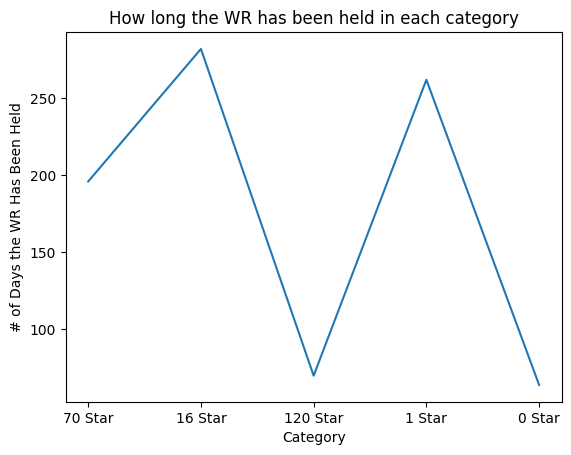

In [28]:
x = df['CATEGORY']
y = df['DAYS_RECORD_HELD']

plt.plot(x, y)
plt.title("How long the WR has been held in each category")
plt.xlabel("Category")
plt.ylabel("# of Days the WR Has Been Held")
plt.show()

In [22]:
#connObj.close